In [1]:
import arviz as az
import numpy as np  # For vectorized math operations

# import pandas as pd  # For file input/output
import pymc as pm
from scipy.stats import gumbel_r
import seaborn as sns
from matplotlib import pyplot as plt

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
%config InlineBackend.figure_format='retina'
sns.set_theme(context='notebook', style='white', font="Latin Modern Roman", rc = {"axes.spines.right": False, "axes.spines.top": False})

# Simulate some data

Data generating process is:
$$
u_{ij} = {x_i}'\beta^{\text{individual}}_{i} + {c_j}'\beta^{\text{product}}_{i} + \eta_{ij} - \eta_{i0}
$$
where
- the consumer knows $\left(x_i, \beta^{\text{individual}}_i, c_j, \beta^{\text{product}}_{i}, \eta_{ij}\right)$, which implies outcome variables $\left(t_i, w_i\right)$
- the econometrician knows $\left(x_i, c_j, t_i, w_i\right)$ and has priors over $\left(\beta^{\text{individual}}, \beta^{\text{product}}\right)$
- neither the consumer nor the econometrician knows $\eta_{i0}$, but they have common priors

Consumer reports
- their preferred good $j^{(1)}$
- the probability they purchase the good on a Likert scale with $W$ categories

## Notation

- $N$ is the number of individuals
- $J$ is the number of products
- $K$ is the number of product attributes
- $M$ is the number of individual attributes
- $W$ is the number of categories on the Likert scale

In [3]:
def make_data(params, heterogeneous=False):

    ## load parameters
    M = params["M"]
    W = params["W"]
    J = params["J"]
    K = params["K"]
    N = params["N"]

    np.random.seed(42)

    ## generate latent parameters
    # individual_features = np.random.normal(0, 0.1, (N, M))
    # individual_features = np.zeros((N, M))
    individual_features = ...
    product_features = np.random.normal(0, 0.2, (J, K))
    π = np.random.dirichlet([1] * W, 1).flatten().cumsum()
    β_ind = ...
    # β_ind = np.random.normal(0, 1, M)
    # β_prod = np.random.normal(0, 0.2, (K, N))
    # ν = np.random.normal(0, 1, (N, J))
    η = np.random.gumbel(0, 1, (N, J))
    # ɛ = np.random.normal(0, 1, (N, J))

    if heterogeneous:
        β_prod = np.random.normal(0, 1, (K, N))
    else:
        β_prod = np.ones((N, 1)) @ np.random.normal(0, 1, (1, K))
    ## generate data
    # y = np.zeros((N, J))

    # u_individual = np.outer(
    #     individual_features @ β_ind,
    #     np.ones(J),
    # )
    u = β_prod @ product_features.T + η

    if heterogeneous:
        u_individual = ...
        u += u_individual

    t = np.argmax(u, axis=1)
    v = u[:, t]
    w = np.digitize(gumbel_r.cdf(v), π)
    
    d = {
        "product_features": product_features,
        "t": t,
        "w": w,
        "latent_cutpoints": π,
        "latent_utilities": u,
        "latent_β_prod": β_prod
    }

    if heterogeneous:
        d["individual_features"] = individual_features

    if heterogeneous:
        d["individual_features"] = individual_features
        d["latent_β_ind"] = β_ind
        
    return d

params = {"N": 200, "J": 3, "K": 5, "M": 2, "W": 4}

df = make_data(params)

First, try "classical" conjoint, in which $\eta_0$ is observed by the consumer.

In [4]:
def gumbel_pdf(x, mu=0, beta=1):
    z = (x - mu)/beta
    return np.exp(-(z + np.exp(-z)))

def gumbel_cdf(x, mu=0, beta=1):
    z = (x - mu)/beta
    return np.exp(-np.exp(-z))

In [5]:
np.sum(np.exp(df["latent_β_prod"][0, :] @ df["product_features"].T))

3.3728033382419236

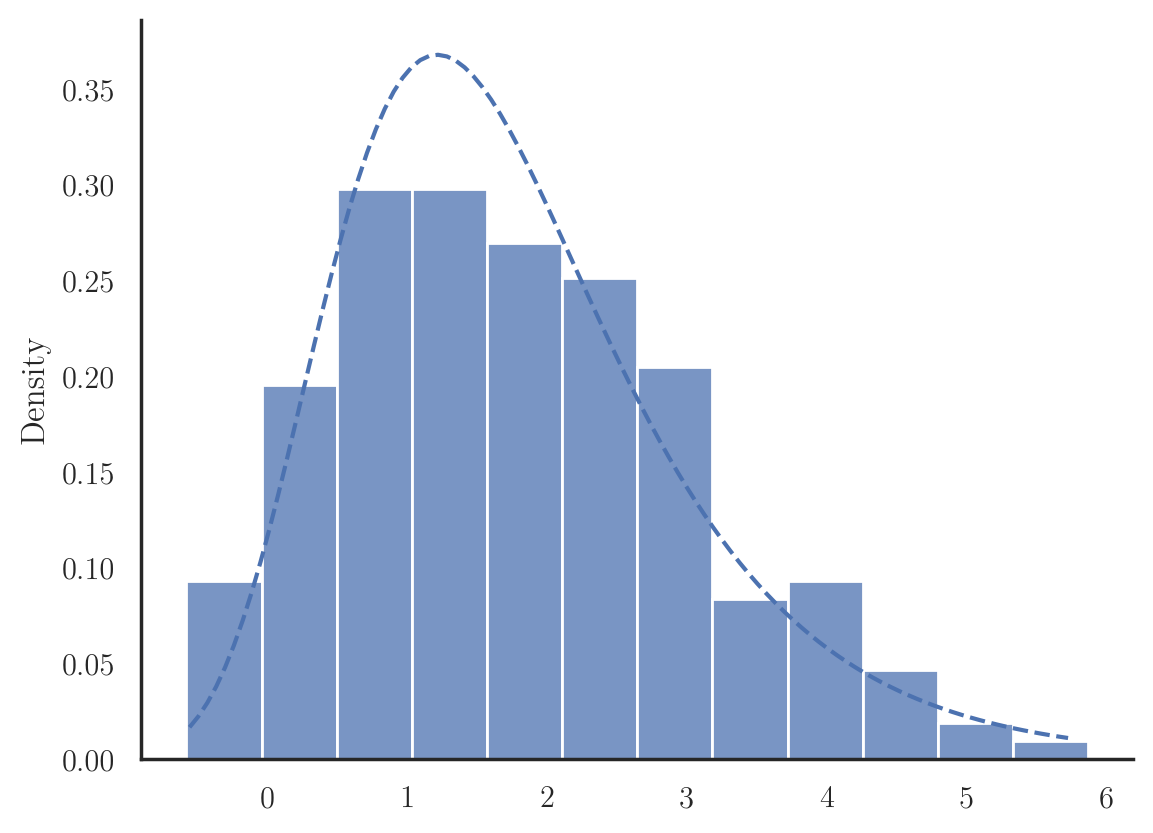

In [6]:
μbar = np.log(np.sum(np.exp(df["latent_β_prod"][0, :] @ df["product_features"].T)))
sns.histplot(np.max(df["latent_utilities"], axis=1), stat="density")
sns.lineplot(
    linestyle="dashed",
    **dict(
        zip(
            ["x", "y"],
            zip(
                *(
                    (x, gumbel_r.pdf(x, μbar))
                    for x in np.linspace(
                        *np.percentile(
                            np.max(df["latent_utilities"], axis=1), [0.1, 99.9]
                        ),
                        100
                    )
                )
            ),
        )
    )
)
plt.show()

In [7]:
df["latent_cutpoints"]

array([0.49851022, 0.57764775, 0.75965146, 1.        ])

In [8]:
dict(
    zip(
        ["x", "y"],
        np.unique(df["w"], return_counts=True)
    )
)

{'x': array([0, 1, 2, 3]), 'y': array([17055,  2895,  7150, 12900])}

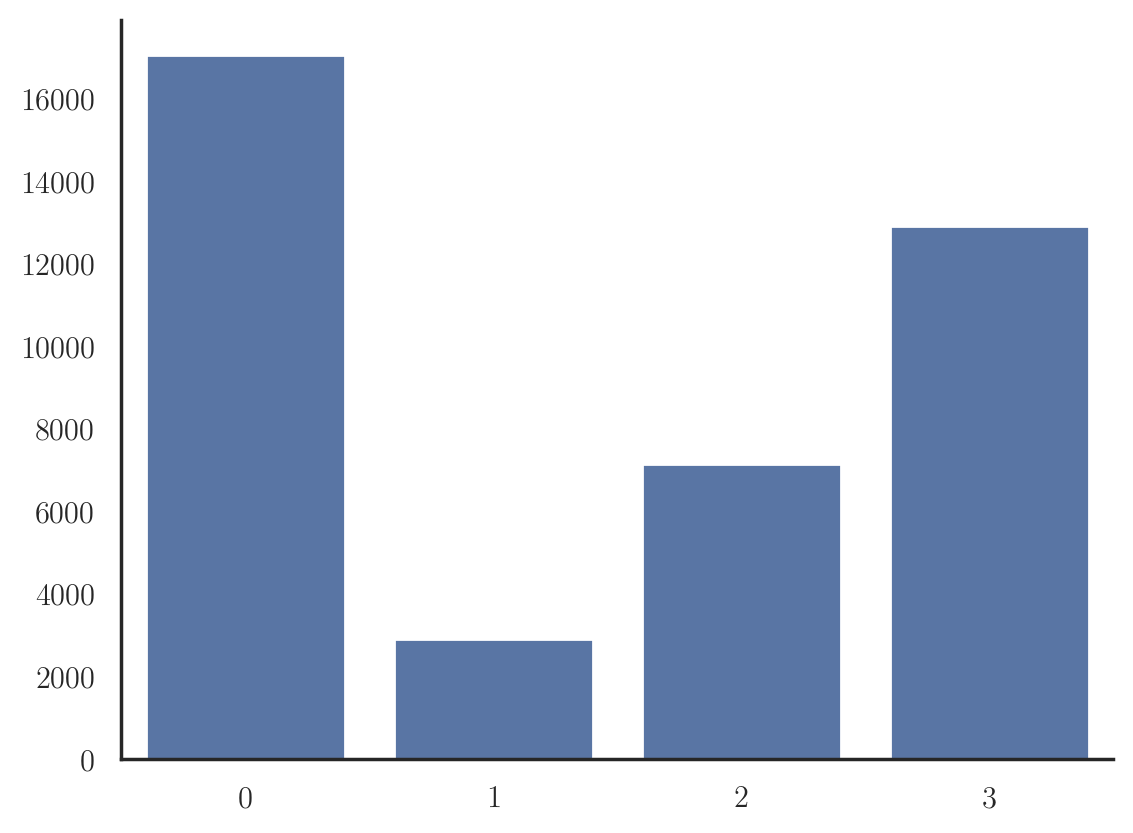

In [9]:
sns.barplot(**dict(zip(["x", "y"], np.unique(df["w"], return_counts=True))))
plt.show()

# Estimate the Model

In [10]:
# import pytensor
# pytensor.config.compute_test_value = 'warn'

In [11]:
observed_good = (df["t"] + 1)
observed_good[np.max(df["latent_utilities"], axis=1) < 0] = 0
observed_bin = df["w"]

N = params["N"]
M = params["M"]
J = params["J"]
K = params["K"]
W = params["W"]
# J, K = df["product_features"].shape
# W = len(np.unique(observed_bin))


coords = {
    "products": [f"product_{i}" for i in range(J+1)],
    "i_factors": [f"if_{i}" for i in range(N)],
    "p_factors": [f"pf_{i}" for i in range(K)],
    "obs": range(N),
}

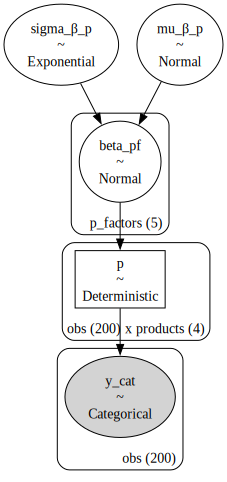

In [12]:
with pm.Model(coords=coords) as model_1:

    mu_β_p = pm.Normal("mu_β_p", 0, 1)
    sigma_β_p = pm.Exponential("sigma_β_p", 1)
    beta_p = (
        pm.math.ones((N, 1))
        * pm.Normal("beta_pf", mu_β_p, sigma_β_p, dims=["p_factors"]).T
    )  # want there to be N*K beta's

    ## Construct Utility matrix

    s_good = beta_p @ df["product_features"].T
    s = pm.math.concatenate([s_good, np.zeros((N, 1))], axis=1)
    
    ## Apply Softmax Transform
    p_ = pm.Deterministic("p", pm.math.softmax(s, axis=1), dims=("obs", "products"))

    ## Likelihood
    choice_obs = pm.Categorical("y_cat", p=p_, observed=observed_good, dims="obs")

pm.model_to_graphviz(model_1)

In [13]:
with model_1:
    idata_m1 = pm.sample_prior_predictive()
    idata_m1.extend(
        pm.sample(
            5000,
            nuts_sampler="numpyro",
            idata_kwargs={"log_likelihood": True},
            random_seed=100,
        )
    )
    idata_m1.extend(pm.sample_posterior_predictive(idata_m1))

Sampling: [beta_pf, mu_β_p, sigma_β_p, y_cat]


  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

Sampling: [y_cat]


Output()

In [14]:
az.summary(idata_m1, var_names=["beta_pf"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_pf[pf_0],-1.180,2.996,-7.049,4.527,0.031,0.025,9871.0,8965.0,1.0
beta_pf[pf_1],1.247,1.784,-2.039,4.689,0.024,0.019,6085.0,5994.0,1.0
beta_pf[pf_2],-2.762,2.226,-7.019,1.376,0.028,0.020,7240.0,7748.0,1.0
beta_pf[pf_3],-2.539,1.283,-4.991,-0.154,0.016,0.012,7233.0,7243.0,1.0
beta_pf[pf_4],3.487,1.775,0.285,6.924,0.024,0.020,6070.0,5979.0,1.0


In [15]:
post = az.extract(idata_m1)

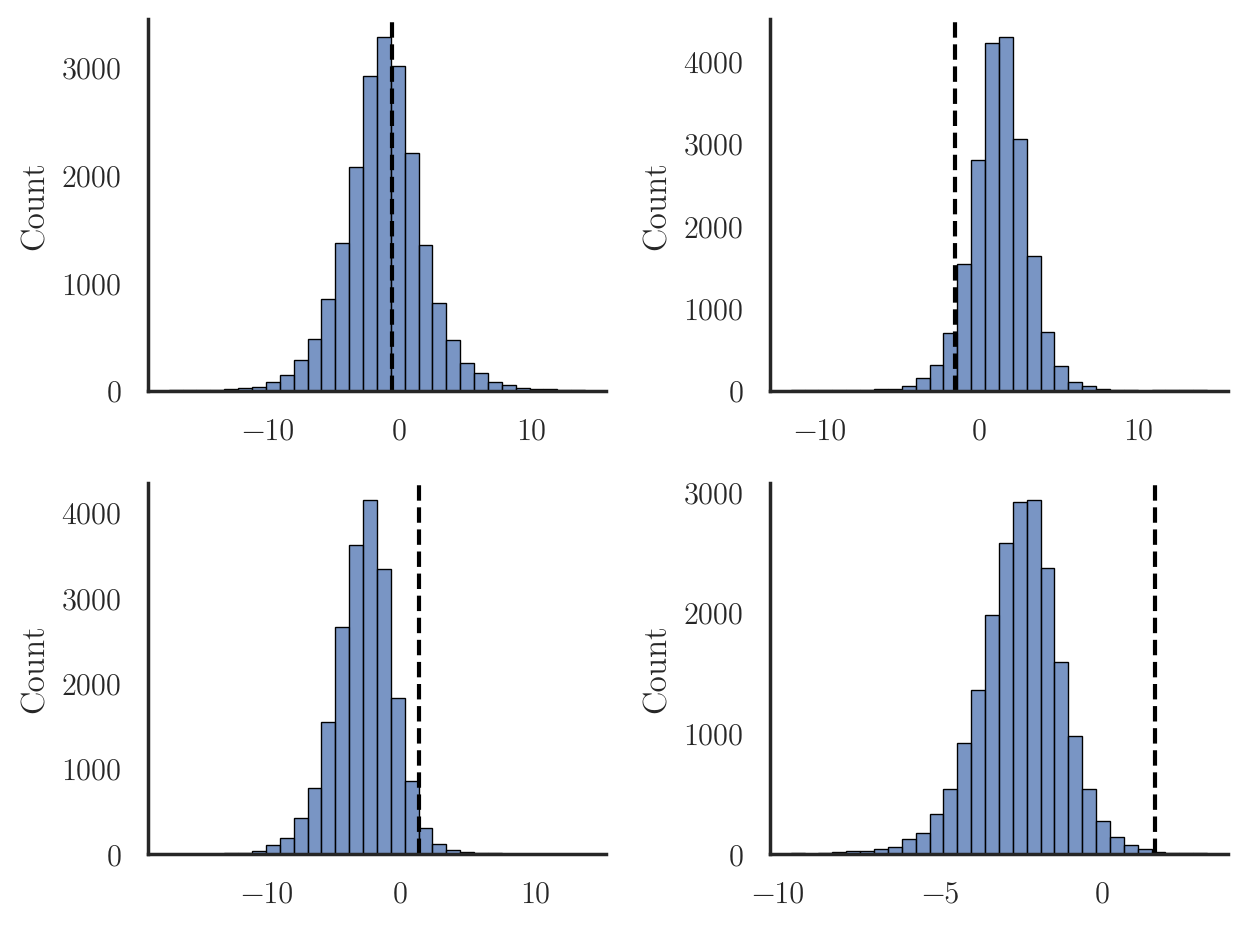

In [16]:
fig, axs = plt.subplots(2, 2)

for i in range(4):
    plt.sca(axs.flatten()[i])
    sns.histplot(
        post["beta_pf"][i, :],
        bins=30,
        ec="black",
    )
    plt.axvline(df["latent_β_prod"][0, i], linestyle="dashed", color="black")

plt.tight_layout()
plt.show()

### Individual-specific $\beta$ (To Do...)

In [17]:
# with pm.Model(coords=coords) as model_1:

#     mu_β_p = pm.Normal("mu_β_p", 0, 1)
#     sigma_β_p = pm.Exponential("sigma_β_p", 5)
#     # beta_p = pm.Normal(
#     #     "beta_pf", mu_β_p, sigma_β_p, dims=["obs", "p_factors"]
#     # )  # want there to be N*K beta's

#     beta_p = (
#         pm.math.ones((N, 1))
#         * pm.Normal("beta_pf", mu_β_p, sigma_β_p, dims=["p_factors"]).T
#     )  # want there to be N*K beta's

#     # beta_p_print = Print("beta_p")(beta_p)

#     # π = pm.Dirichlet("latent_binwidths", a=pm.math.ones(W))  # W x 1
#     # α = pm.Deterministic(
#     #     "latent_cutpoints", pt.concatenate([np.ones(1) * 0, pt.extra_ops.cumsum(π)])
#     # )  # (W+1) x 1

#     ## Construct Utility matrix

#     # s_good = pm.math.dot(beta_p, df["product_features"].T)  # N x J
    
#     s_good = beta_p @ df["product_features"].T

#     # individual_effects = pm.math.sum(pm.math.dot(beta_i, df["individual_features"]), axis=1)
#     # s_person = individual_effects[:, None] * pm.math.ones_like(df["individual_features"])
#     # s = s_good + 0

#     # s_good_print = Print("s_good")(s_good)

#     s = pm.math.concatenate([s_good, np.zeros((N, 1))], axis=1)
#     ## Calculate good conditional likelihoods
#     # p_goods = pm.math.softmax(s, axis=1)  # probability that good i is best of J

#     ## Apply Gumbel-Max Adjustment
#     # μbar = pm.math.log(pm.math.sum(pm.math.exp(s), axis=1))  # should be N x 1

#     ## Apply Softmax Transform
#     p_ = pm.Deterministic("p", pm.math.softmax(s, axis=1), dims=("obs", "products"))

#     ## Likelihood
#     choice_obs = pm.Categorical("y_cat", p=p_, observed=observed_good, dims="obs")

#     # sandwich_meat = [
#     #     (
#     #         pm.math.exp(pm.math.exp(μbar) * pm.math.log(α[w]))
#     #         - pm.math.exp(pm.math.exp(μbar) * pm.math.log(α[w - 1]))
#     #     )
#     #     for w in range(2, W)
#     # ]

#     # ## Calculate bin conditional likelihoods
#     # p_bins = pt.stack(
#     #     [
#     #         pm.math.exp(pm.math.exp(μbar) * pm.math.log(α[1])),  # should be N x 1
#     #         *sandwich_meat,  # should be N x W-2
#     #         1 - pm.math.exp(pm.math.exp(μbar) * pm.math.log(α[-1])),  # should be N x 1
#     #     ],
#     #     axis=0,
#     # ).T  # should be N x W

#     ## Map to observables
#     # good_obs = pm.Categorical("product", p=p_goods, observed=observed_good, dims="obs")
#     # outside_obs =
#     # prob_obs = pm.Categorical("bin", p=probs, observed=observed_prob, dims="obs")
#     # bin_obs = pm.Categorical("bin", p=p_bins, observed=observed_bin, dims="obs")

# pm.model_to_graphviz(model_1)

In [18]:
# az.summary(idata_m1, var_names=["mu_β_p", "sigma_β_p", "latent_cutpoints"])